In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
from wordcloud import WordCloud

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Step 1: Load Data
def load_data():
    fake = pd.read_csv(r"C:\Users\DELL\Videos\ml\Fake.csv")
    true = pd.read_csv(r"C:\Users\DELL\Videos\ml\True.csv")
    fake['label'] = 0  # 0 = Fake
    true['label'] = 1  # 1 = Real
    df = pd.concat([fake, true], axis=0).sample(frac=1).reset_index(drop=True)
    df = df[['title', 'label']].rename(columns={'title': 'text'})
    return df

In [5]:
# Step 2: Clean Text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [6]:
# Step 3: Visualizations
def plot_class_distribution(df):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='label')
    plt.xticks([0, 1], ['Fake', 'Real'])
    plt.title("Class Distribution: Fake vs Real")
    plt.savefig("class_distribution.png")
    plt.show()

In [7]:
def plot_wordclouds(df):
    fake_words = " ".join(df[df['label'] == 0]['text'])
    real_words = " ".join(df[df['label'] == 1]['text'])

    wordcloud_fake = WordCloud(background_color='black').generate(fake_words)
    wordcloud_real = WordCloud(background_color='white').generate(real_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_fake, interpolation='bilinear')
    plt.axis("off")
    plt.title("Fake News WordCloud")
    plt.savefig("wordcloud_fake.png")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis("off")
    plt.title("Real News WordCloud")
    plt.savefig("wordcloud_real.png")
    plt.show()

In [8]:
# Step 4: Train & Compare Models
def train_and_compare(df):
    df['cleaned'] = df['text'].apply(clean_text)
    df['polarity'] = df['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

    tfidf = TfidfVectorizer(max_features=5000)
    X_text = tfidf.fit_transform(df['cleaned'])
    X = hstack([X_text, np.array(df['polarity']).reshape(-1, 1)])
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model 1: Logistic Regression
    print("🔸 Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Logistic Regression Accuracy: {acc_lr:.4f}")

    # Model 2: Random Forest (before tuning)
    print("🔸 Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Random Forest Accuracy: {acc_rf:.4f}")

    # Model 3: Hyperparameter Tuned RF
    print("🔍 Tuning Random Forest with GridSearchCV...")
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    }
    grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, cv=3)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred_best = best_model.predict(X_test)
    acc_best = accuracy_score(y_test, y_pred_best)

    print(f"✅ Best Random Forest Accuracy: {acc_best:.4f}")
    print(classification_report(y_test, y_pred_best))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title("Confusion Matrix (Best RF)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("confusion_matrix.png")
    plt.show()

    # Feature importance
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]

    feature_names = list(tfidf.get_feature_names_out())
    feature_names.append("polarity")  # add the extra feature name
    top_features = [feature_names[i] for i in indices]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=importances[indices], y=top_features)
    plt.title("Top 10 Important Features (TF-IDF + Polarity)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    plt.show()

    # Save model & vectorizer
    joblib.dump(best_model, "fake_news_model.pkl")
    joblib.dump(tfidf, "tfidf_vectorizer.pkl")
    print("✅ Model and vectorizer saved successfully!")

In [9]:
# Step 5: Run Everything
def main():
    print("🚀 Starting Fake News Detection Training...")
    df = load_data()
    plot_class_distribution(df)
    plot_wordclouds(df)
    train_and_compare(df)
    print("🎉 Training pipeline completed successfully!")

🚀 Starting Fake News Detection Training...


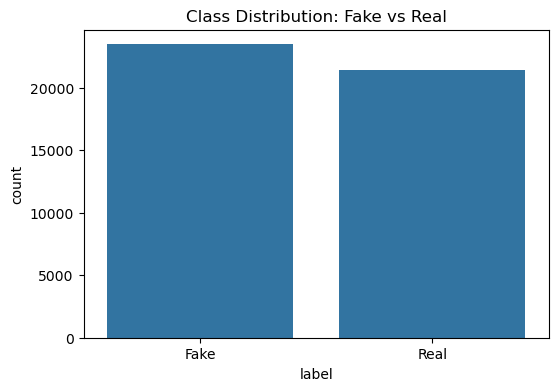

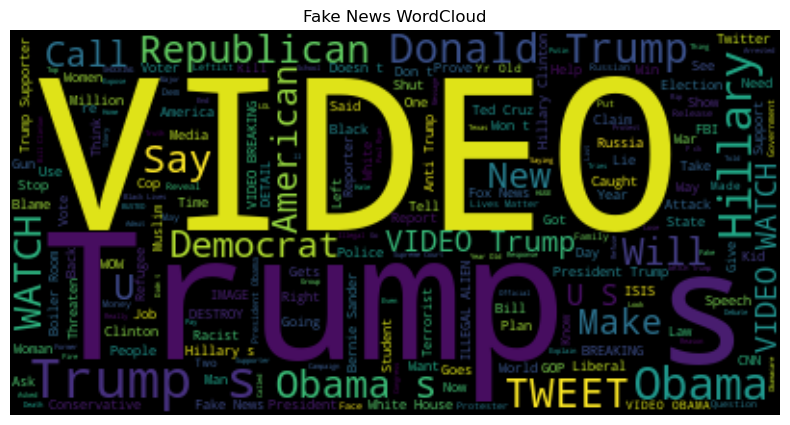

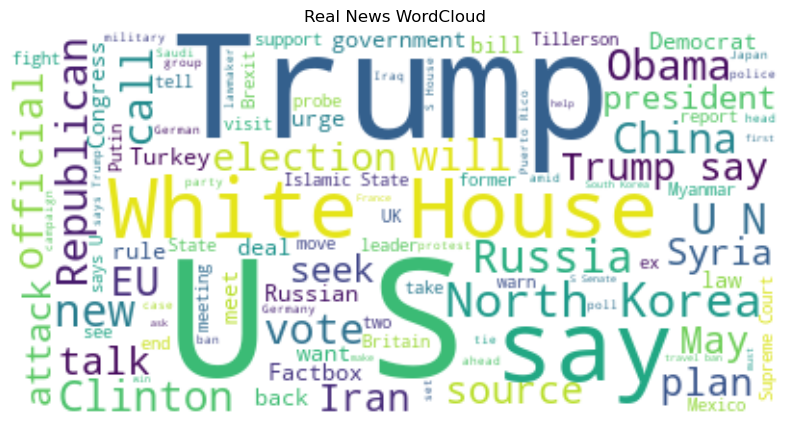

KeyboardInterrupt: 

In [10]:
if __name__ == "__main__":
    main()